In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

https://www.kaggle.com/jorekai/anomaly-detection-falling-people-events

## Load & preprocess data

In [2]:
path = "../data/"

In [3]:
def load_data(path):
    list_of_frames = []
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            list_of_frames.append(pd.read_csv(path + filename))
    return list_of_frames

In [4]:
train_data = load_data(path + "train/")
test_data = load_data(path + "test/")

In [5]:
len(train_data), len(test_data)

(20, 5)

<AxesSubplot:xlabel='y', ylabel='z'>

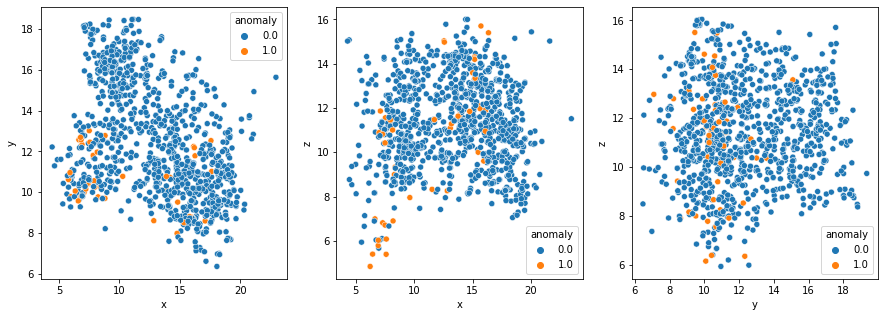

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(data=pd.concat(train_data).sample(n=1000), x="x", y="y", hue="anomaly")
plt.subplot(1, 3, 2)
sns.scatterplot(data=pd.concat(train_data).sample(n=1000), x="x", y="z", hue="anomaly")
plt.subplot(1, 3, 3)
sns.scatterplot(data=pd.concat(train_data).sample(n=1000), x="y", y="z", hue="anomaly")

In [6]:
def preproc(data):
    for i in range(len(data)):
        data[i].x = (data[i].x - data[i].x.min()) / (data[i].x.max() - data[i].x.min())
        data[i].y = (data[i].y - data[i].y.min()) / (data[i].y.max() - data[i].y.min())
        data[i].z = (data[i].z - data[i].z.min()) / (data[i].z.max() - data[i].z.min())
        data[i] = data[i].drop(
            [
                "010-000-024-033",
                "010-000-030-096",
                "020-000-032-221",
                "020-000-033-111",
            ],
            axis=1,
        )
    return data

In [7]:
train_data = preproc(train_data)
test_data = preproc(test_data)

In [8]:
sns.set(rc={"figure.figsize": (15, 5)})

<AxesSubplot: >

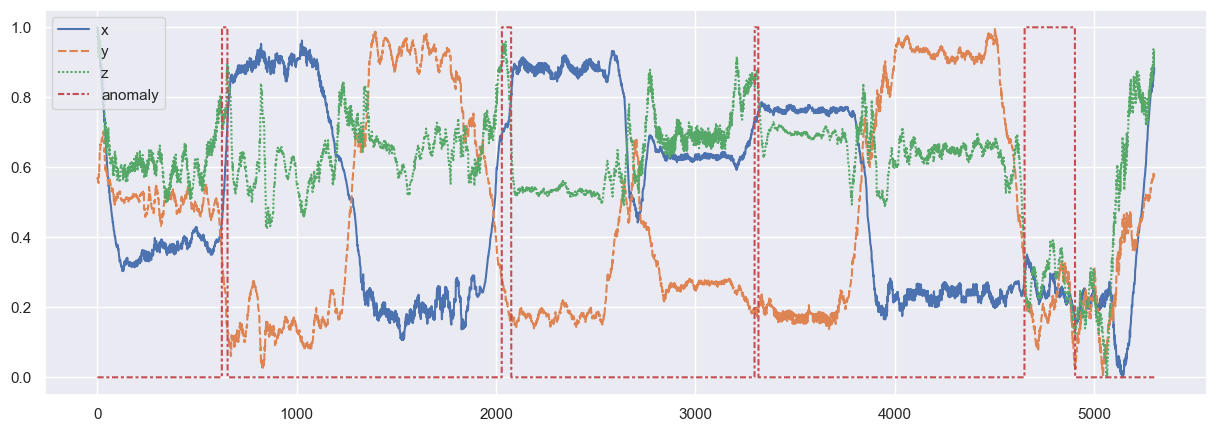

In [9]:
sns.lineplot(data=train_data[3].loc[:, ["x", "y", "z", "anomaly"]])

## Feature Engineering

In [10]:
pd.set_option("use_inf_as_na", True)

In [11]:
def feature_engineering(data, window1, window2, window3, window4):
    for df in data:
        df["x1"] = df.x.rolling(window1).mean().ffill().bfill()
        df["y1"] = df.y.rolling(window1).mean().ffill().bfill()
        df["z1"] = df.z.rolling(window1).mean().ffill().bfill()
        df["x2"] = df.x.rolling(window2).mean().ffill().bfill()
        df["y2"] = df.y.rolling(window2).mean().ffill().bfill()
        df["z2"] = df.z.rolling(window2).mean().ffill().bfill()

        df["x3"] = (
            ((df.x - df.x.rolling(window4).mean()) / df.x.rolling(window4).std())
            .ffill()
            .bfill()
        )
        df["y3"] = (
            ((df.y - df.y.rolling(window4).mean()) / df.y.rolling(window4).std())
            .ffill()
            .bfill()
        )
        df["z3"] = (
            ((df.z - df.z.rolling(window4).mean()) / df.z.rolling(window4).std())
            .ffill()
            .bfill()
        )

        df["x4"] = (
            ((df.x3 - df.x3.rolling(window3).mean()) / df.x3.rolling(window3).std())
            .ffill()
            .bfill()
        )
        df["y4"] = (
            ((df.y3 - df.y3.rolling(window3).mean()) / df.y3.rolling(window3).std())
            .ffill()
            .bfill()
        )
        df["z4"] = (
            ((df.z3 - df.z3.rolling(window3).mean()) / df.z3.rolling(window3).std())
            .ffill()
            .bfill()
        )

        df["xy"] = df.x * df.y
        df["yz"] = df.y * df.z
        df["xz"] = df.x * df.z
        df["xyz"] = df.x * df.y * df.z

        df["x-y"] = df.x - df.y
        df["x-z"] = df.x - df.z
        df["z-y"] = df.z - df.y
        df["x+y+z"] = df.x + df.y + df.z

    return data

In [12]:
def feature_engineering1(data, window1, window2):
    for df in data:

        df["x^2"] = df.x**2
        df["VARx"] = (df["x^2"].rolling(window1).sum() / (window1 - 1)).ffill().bfill()
        df["RMSx"] = np.sqrt(df["x^2"].rolling(window1).sum() / window1).ffill().bfill()

        df["y^2"] = df.x**2
        df["VARy"] = (df["y^2"].rolling(window1).sum() / (window1 - 1)).ffill().bfill()
        df["RMSy"] = np.sqrt(df["y^2"].rolling(window1).sum() / window1).ffill().bfill()

        df["z^2"] = df.x**2
        df["VARz"] = (df["z^2"].rolling(window1).sum() / (window1 - 1)).ffill().bfill()
        df["RMSz"] = np.sqrt(df["z^2"].rolling(window1).sum() / window1).ffill().bfill()

        df["x^22"] = df.x**2
        df["VARx2"] = (df["x^2"].rolling(window2).sum() / (window2 - 1)).ffill().bfill()
        df["RMSx2"] = (
            np.sqrt(df["x^22"].rolling(window2).sum() / window2).ffill().bfill()
        )

        df["y^22"] = df.x**2
        df["VARy2"] = (df["y^2"].rolling(window2).sum() / (window2 - 1)).ffill().bfill()
        df["RMSy2"] = (
            np.sqrt(df["y^22"].rolling(window2).sum() / window2).ffill().bfill()
        )

        df["z^22"] = df.x**2
        df["VARz2"] = (df["z^2"].rolling(window2).sum() / (window2 - 1)).ffill().bfill()
        df["RMSz2"] = (
            np.sqrt(df["z^22"].rolling(window2).sum() / window2).ffill().bfill()
        )

    return data

In [13]:
train_data1 = feature_engineering(train_data, 10, 30, 200, 500)
test_data1 = feature_engineering(test_data, 10, 30, 200, 500)

In [14]:
train_data1 = feature_engineering1(train_data, 30, 10)
test_data1 = feature_engineering1(test_data, 30, 10)

## ML

In [15]:
def train_model(model, model_name):
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred1 = model.predict(X_train)

    print("Train")
    print(classification_report(y_train, pred1))
    print("Test")
    print(classification_report(y_test, pred))
    return pred

In [16]:
all_train = pd.concat(train_data1)
all_test = pd.concat(test_data1)
X_train = all_train.drop(["anomaly"], axis=1)
y_train = all_train.anomaly
X_test = all_test.drop(["anomaly"], axis=1)
y_test = all_test.anomaly

### CatBoost

In [17]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [18]:
cat = CatBoostClassifier(
    verbose=0, n_estimators=1500, class_weights=class_weights, learning_rate=0.05
)
pred = train_model(cat, "Cat Boost")

Train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    127656
         1.0       0.96      1.00      0.98      6573

    accuracy                           1.00    134229
   macro avg       0.98      1.00      0.99    134229
weighted avg       1.00      1.00      1.00    134229

Test
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     28420
         1.0       0.67      0.68      0.68      1610

    accuracy                           0.97     30030
   macro avg       0.83      0.83      0.83     30030
weighted avg       0.97      0.97      0.97     30030



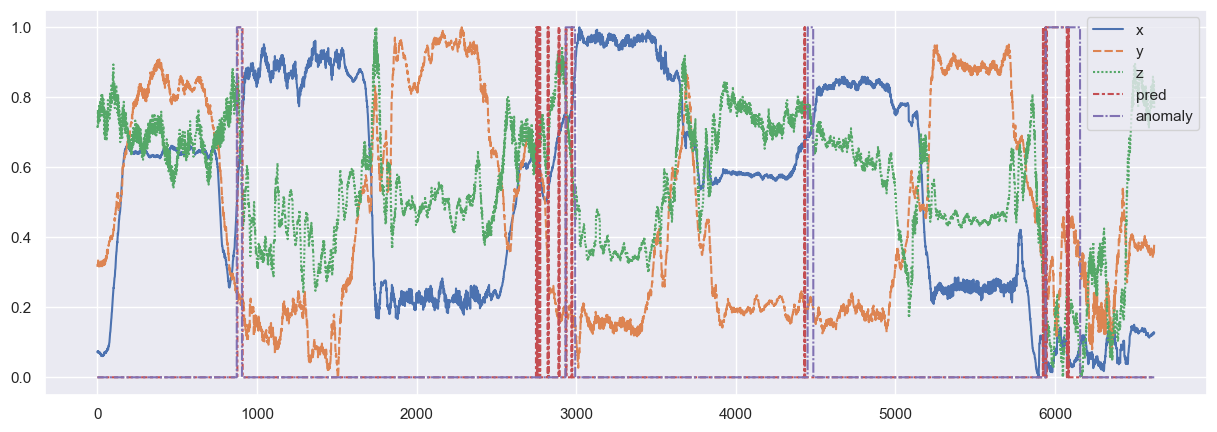

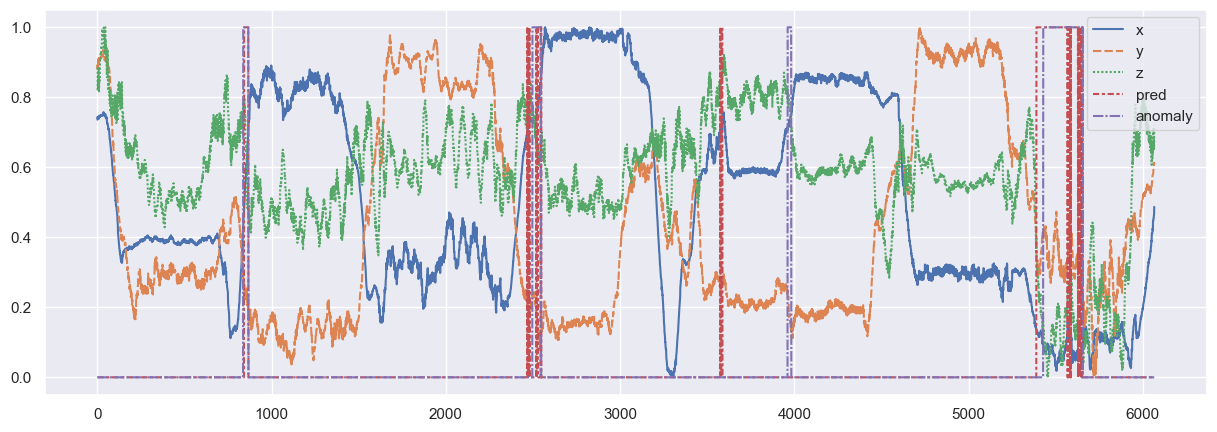

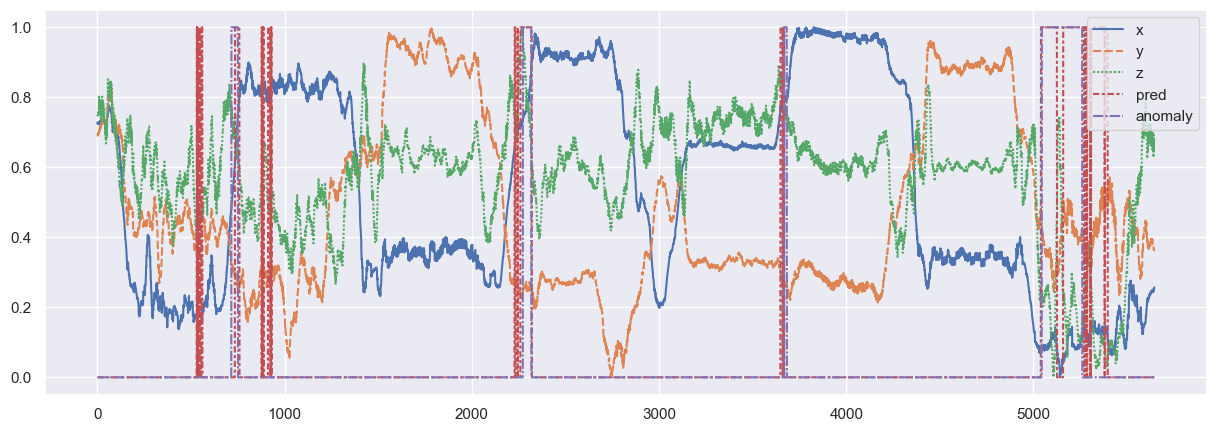

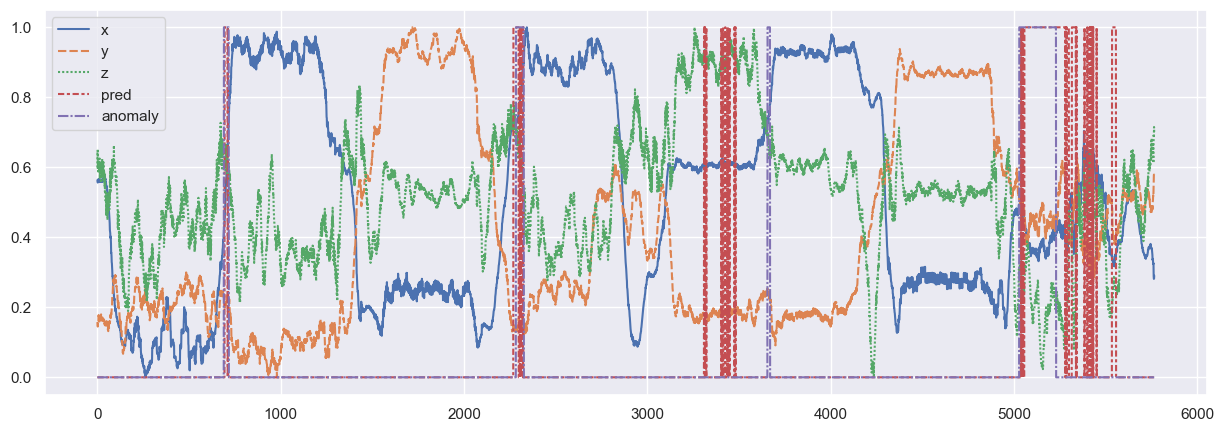

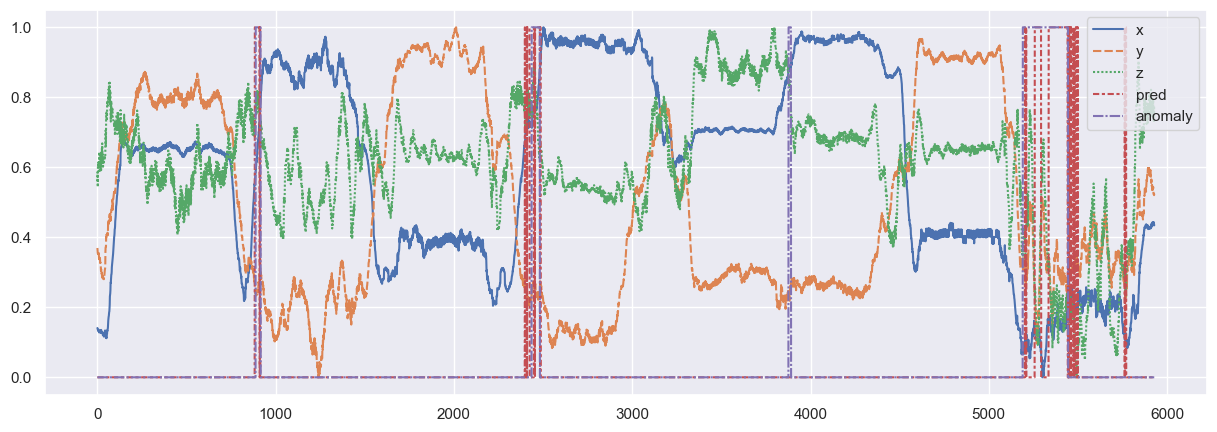

In [19]:
for i in range(len(test_data1)):
    X_test = test_data1[i].drop(["anomaly"], axis=1)
    y_test = test_data1[i].anomaly
    pred = cat.predict(X_test)

    plt.figure()
    test_data1[i]["pred"] = pred
    sns.lineplot(data=test_data1[i].loc[:, ["x", "y", "z", "pred", "anomaly"]])

### XGBoost

In [20]:
scale_pos_weight = y_train.value_counts().max() / y_train.value_counts().min()

In [21]:
xgb = XGBClassifier(
    n_estimators=1500,
    nthread=4,
    max_depth=7,
    min_child_weight=1,
    learning_rate=0.01,
    scale_pos_weight=scale_pos_weight,
)
train_model(xgb, "XGBClassifier")

Train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    127656
         1.0       0.91      1.00      0.95      6573

    accuracy                           1.00    134229
   macro avg       0.96      1.00      0.98    134229
weighted avg       1.00      1.00      1.00    134229

Test
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      5587
         1.0       0.72      0.71      0.72       342

    accuracy                           0.97      5929
   macro avg       0.85      0.85      0.85      5929
weighted avg       0.97      0.97      0.97      5929



array([0, 0, 0, ..., 0, 0, 0])

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

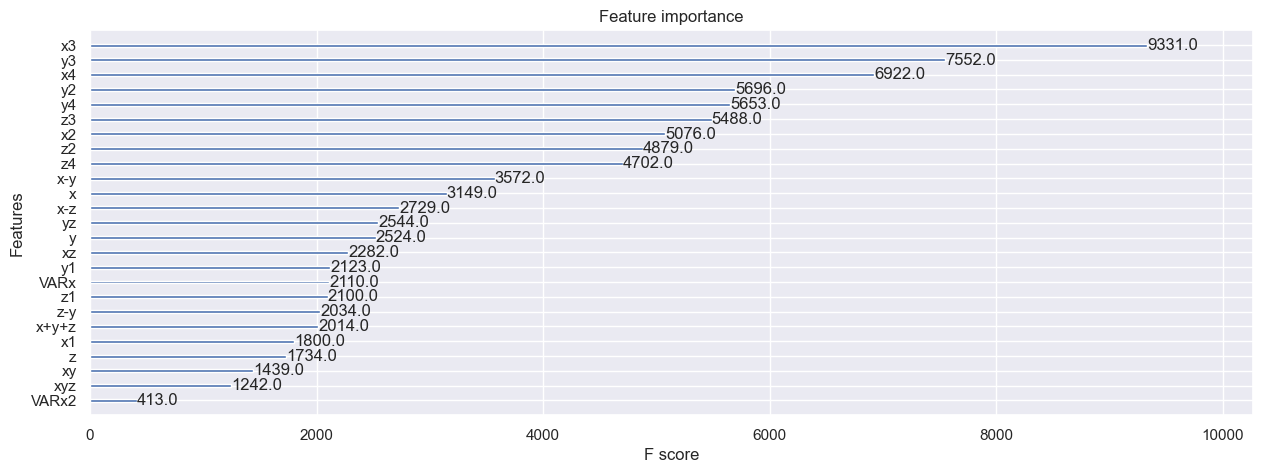

In [22]:
from xgboost import plot_importance

plot_importance(
    xgb,
)

In [23]:
rf = RandomForestClassifier(
    n_estimators=1500,
    criterion="entropy",
    n_jobs=-1,
    max_depth=12,
    class_weight=class_weights,
)
train_model(rf, "Random Forest Classifier")

Train
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    127656
         1.0       0.50      1.00      0.66      6573

    accuracy                           0.95    134229
   macro avg       0.75      0.97      0.82    134229
weighted avg       0.98      0.95      0.96    134229

Test
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      5587
         1.0       0.49      0.67      0.56       342

    accuracy                           0.94      5929
   macro avg       0.73      0.81      0.77      5929
weighted avg       0.95      0.94      0.94      5929



array([0., 0., 0., ..., 0., 0., 0.])